In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

In [4]:
df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

In [5]:
df_train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Check shape of train data set i.e columns and rows count.

In [6]:
df_train.shape

(1460, 81)

Check shape of test data set i.e columns and rows count.

In [7]:
df_test.shape

(1459, 80)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Check if any columns have missing values.

In [9]:
df_train.columns[df_train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

Check the percentage of missing values in these columns.

In [10]:
#missing value counts in each of these columns
miss = df_train.isnull().sum()/len(df_train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Electrical      0.000685
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtExposure    0.026027
BsmtFinType2    0.026027
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
LotFrontage     0.177397
FireplaceQu     0.472603
Fence           0.807534
Alley           0.937671
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64

Visualising and plot the missing value count.

In [11]:
df_miss = miss.to_frame()

In [12]:
df_miss.columns = ['Mean(count)']
df_miss.index.names = ['Name']
df_miss['Name'] = df_miss.index

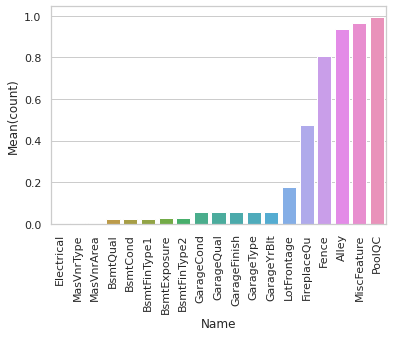

In [13]:
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'Mean(count)', data=df_miss)
plt.xticks(rotation = 90)
plt.show()

Proceed and check the distribution of the target variable.

(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.,  600000.,  700000.,  800000.,  900000.]),
 <a list of 11 Text major ticklabel objects>)

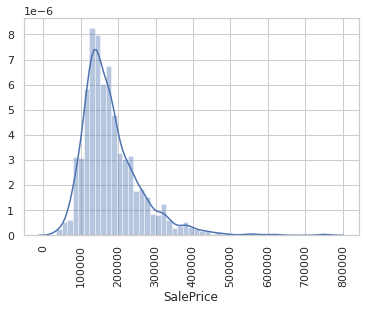

In [14]:
#SalePrice
sns.distplot(df_train['SalePrice'])
plt.xticks(rotation = 'vertical')

In [15]:
#skewness
print("The skewness of SalePrice is {}".format(df_train['SalePrice'].skew()))

The skewness of SalePrice is 1.8828757597682129


The target variable SalePrice has a right-skewed distribution. We'll need to log transform this variable so that it becomes normally distributed.

Skewness is 0.12133506220520406


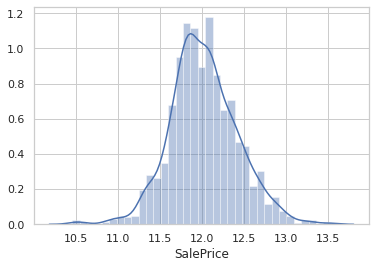

In [16]:
#now transforming the target variable
target = np.log(df_train['SalePrice'])
print ('Skewness is', target.skew())
sns.distplot(target)

In [17]:
#separate variables into new data frames
numeric_data = df_train.select_dtypes(include=[np.number])
cat_data = df_train.select_dtypes(exclude=[np.number])

In [18]:
## Count of numerical columns 
numeric_data.shape

(1460, 38)

In [19]:
cat_data.shape

(1460, 43)

In [20]:
del numeric_data['Id']

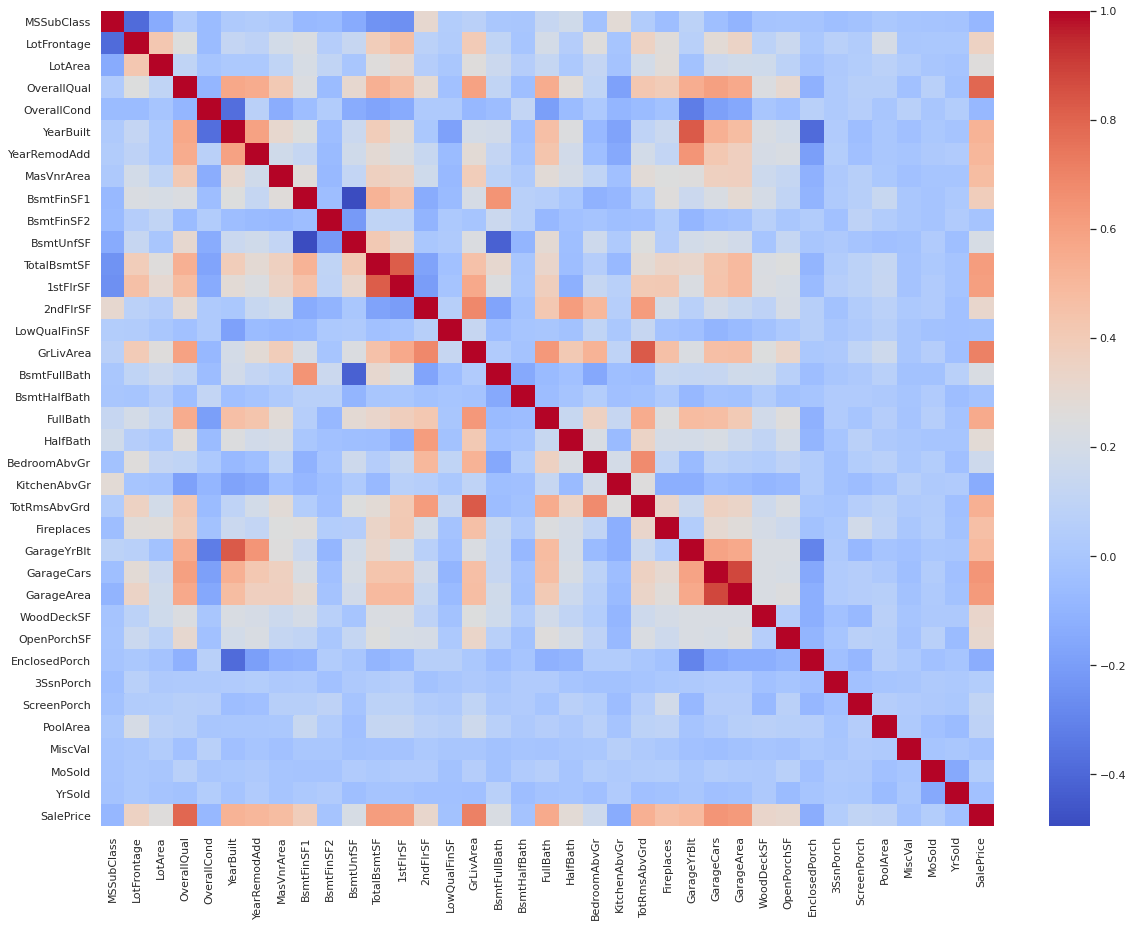

In [21]:
#correlation plot
corr = numeric_data.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, cmap='coolwarm')

In [22]:
print (corr['SalePrice'].sort_values(ascending=False)[:15], '\n') #top 15 values
print ('----------------------')
print (corr['SalePrice'].sort_values(ascending=False)[-5:]) #last 5 values

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64 

----------------------
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [23]:
df_train['OverallQual'].unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [25]:
## We are using median because the target variable is skewed. A skewed variable has outliers and median is robust to outliers.

#let's check the mean price per quality and plot it.
pivot = df_train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


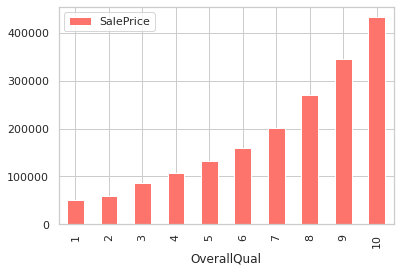

In [35]:
## Let's plot this table and understand the median behavior using a bar graph.

pivot.plot(kind='bar', color='#FD746C')

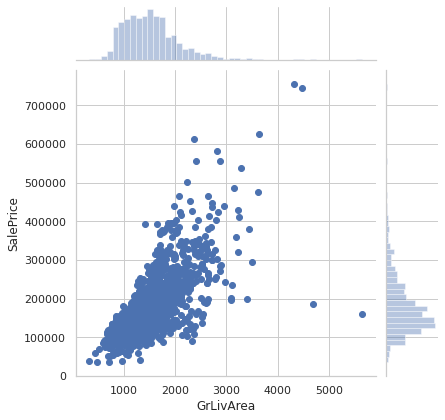

In [28]:
## Visualize the correlated variable GrLivArea and understand their behavior.

#GrLivArea variable
sns.jointplot(x='GrLivArea', y='SalePrice', data=df_train)

In [29]:
## Understand categorical variables using .describe() command.
cat_data.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [32]:
## Let's check the median sale price of a house based on its SaleCondition. SaleCondition explains the condition of sale. 

sp_pivot = df_train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
sp_pivot

,SalePrice
SaleCondition,
Abnorml,130000
AdjLand,104000
Alloca,148145
Family,140500
Normal,160000
Partial,244600


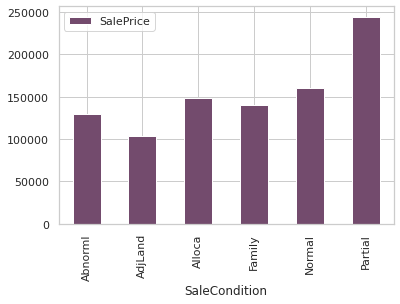

In [34]:
sp_pivot.plot(kind='bar',color='#734b6d')

#### Use the ANOVA test to understand the correlation between categorical variables and SalePrice. ANOVA test is a statistical technique used to determine if there exists a significant difference in the mean of groups.

While using ANOVA, our hypothesis is as follows:

Ho - There exists no significant difference between the groups. Ha - There exists a significant difference between the groups.

Now, we'll define a function which calculates p values. From those p values, we'll calculate a disparity score. Higher the disparity score, better the feature in predicting sale price.

In [ ]:
cat = [f for f in df_train.columns if df_train.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
           samples = []
           for cls in frame[c].unique():
                  s = frame[frame[c] == cls]['SalePrice'].values
                  samples.append(s)
           pval = stats.f_oneway(*samples)[1]
           pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_data['SalePrice'] = df_train.SalePrice.values
k = anova(cat_data) 
k['disparity'] = np.log(1./k['pval'].values) 
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 